# Siddon Algorithm

This is what I plan to turn into a script.

I'm not sure if the graphical representation stuff will be added but it's nice to have for now.

*NOTE: perhaps I want to add X,Y,Z as constants at the top so that I can use them instead of magic numbers as indices* 

The attenuation coefficients are taken from https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html and https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html.

In [1]:
import siddon as sd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate
from topas2numpy import BinnedResult
import spekpy as sp
from numpy import linalg

In [2]:
def alpha_func(plane,coor1,coor2):
    '''
    plane is assumed to be already calculated
    '''
    return (plane-coor1)/(coor2-coor1)

In [3]:
def plane_func(index,plane1,d):
    '''
    Parameters:
    ----------
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    plane1 :: float 
      location of plane with index 1 
    
    d :: float 
      distance between planes
    
    Returns:
    -------
    plane_location :: float 
      the location of the plane of the specified index
    
    '''
    return plane1 + (index-1)*d

In [4]:
def voxel_length(alpha,index,d12):
    '''
    Parameters:
    ----------
    alpha :: list
      list of alpha values
    
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    d12 :: float
      distance from point one to point two
    
    Returns:
    -------
    voxel_length :: float
      voxel intersection length
      
    '''
    
    return d12*(alpha[index]-alpha[index-1])

In [5]:
def voxel_indices(plane1s,coor1s,coor2s,distances,alpha,index):
    '''
    Parameters:
    ----------
    plane1s :: array
      coordinate plane (1) in form (x,y,z)
    
    coor1s :: array
      coordinate one in form (x,y,z)
    
    coor2s :: float
      coordinate two in form (x,y,z)
    
    distances :: float
      distance between two planes in form (x,y,z)
      
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    voxel_index :: integer
      voxel index for the specific coordinate 
    
    '''
    a_mid = alpha_mid(alpha,index)
    
    i = int(np.floor(1 + (coor1s[0] + a_mid*(coor2s[0]-coor1s[0])-plane1s[0])/distances[0]))
    j = int(np.floor(1 + (coor1s[1] + a_mid*(coor2s[1]-coor1s[1])-plane1s[1])/distances[1]))
    k = int(np.floor(1 + (coor1s[2] + a_mid*(coor2s[2]-coor1s[2])-plane1s[2])/distances[2]))
    
    return (i,j,k)

In [6]:
def alpha_mid(alpha,index):
    '''
    Parameters:
    ----------
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    alpha_mid :: float 
    
    '''
    return (alpha[index]+alpha[index-1])/2

In [7]:
def plot_grid_3D(size,bins,ifig=None,colour='b'):
    '''
    size :: tuple
      (x size, y size, z size) in centimeters
    
    bins :: tuple 
      (number of x bins, number of y bins, number of z bins)
    '''
    xlines = np.linspace(0,size[0],bins[0]+1)
    ylines = np.linspace(0,size[1],bins[1]+1)
    zlines = np.linspace(0,size[2],bins[2]+1)
    
    plt.close(ifig)
    fig = plt.figure(ifig)
    ax = plt.axes(projection='3d')
    
    for z in zlines:
        for x in xlines:
            ax.plot3D([x,x],[0,size[1]],z,colour)
        for y in ylines:
            ax.plot3D([0,size[0]],[y,y],z,colour)
    
    for y in ylines:
        for x in xlines:
            ax.plot3D([x,x],[y,y],[0,size[2]],colour)
    
    return ax,fig

In [8]:
def density(index):
    '''
    THIS FUNCTION IS ONLY FOR WATER RIGHT NOW 
    
    Parameters:
    ----------
    index :: tuple (3)
      indices of the voxel whose density you want
    
    Returns:
    -------
    density :: float
      density of that voxel in g/cm^3 
    
    '''
    
    return 1

In [9]:
def Siddon(num_planes,voxel_lengths,beam_coor,ini_planes,plot=False):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    plot :: bool
      if True, plots a graphical representation of the problem
    
    Returns:
    -------
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), and 'indices' (the (x,y,z) indices of the voxel)
    
    '''
    coor_values = {'x':{},'y':{},'z':{}}

    coor_values['x']['N'] = num_planes[0]
    coor_values['y']['N'] = num_planes[1]
    coor_values['z']['N'] = num_planes[2]

    coor_values['x']['d'] = voxel_lengths[0]
    coor_values['y']['d'] = voxel_lengths[1]
    coor_values['z']['d'] = voxel_lengths[2]

    coor_values['x']['1,2'] = beam_coor[0]
    coor_values['y']['1,2'] = beam_coor[1]
    coor_values['z']['1,2'] = beam_coor[2]

    coor_values['x']['plane'] = [ini_planes[0]] # this ends up being min,max
    coor_values['y']['plane'] = [ini_planes[1]]
    coor_values['z']['plane'] = [ini_planes[2]]

    for key in coor_values.keys():
        coor_values[key]['plane'].append(plane_func(coor_values[key]['N'],coor_values[key]['plane'][0],coor_values[key]['d']))

    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
            coor_values[key]['alpha_minmax'] = (alpha_func(coor_values[key]['plane'][0],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]),alpha_func(coor_values[key]['plane'][-1],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]))
        else:
            coor_values[key]['alpha_minmax'] = (0,1) # set to this so that it doesn't affect later business

    alpha_min = max(0,min(coor_values['x']['alpha_minmax']),min(coor_values['y']['alpha_minmax']),min(coor_values['z']['alpha_minmax']))
    alpha_max = min(1,max(coor_values['x']['alpha_minmax']),max(coor_values['y']['alpha_minmax']),max(coor_values['z']['alpha_minmax']))
    
    
    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] >= 0:
            indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmax = 1 - (coor_values[key]['plane'][0]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmin = int(np.ceil(indmin))
            indmax = int(np.floor(indmax))
            coor_values[key]['indminmax'] = (indmin,indmax)
        else:
            indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmax = 1 - (coor_values[key]['plane'][0]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmin = int(np.ceil(indmin))
            indmax = int(np.floor(indmax))
            coor_values[key]['indminmax'] = (indmin,indmax)
    
    alpha_coor_set = {}

    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] > 0:
            coor_values[key]['alpha_set'] = alpha_func(plane_func(np.array([n for n in range(coor_values[key]['indminmax'][0],coor_values[key]['indminmax'][1]+1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
        elif coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] < 0:
            coor_values[key]['alpha_set'] = alpha_func(plane_func(np.array([n for n in range(coor_values[key]['indminmax'][1],coor_values[key]['indminmax'][0]-1,-1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
        else:
            coor_values[key]['alpha_set'] = []    
    
    alpha = [alpha_min,alpha_max] + list(coor_values['x']['alpha_set']) + list(coor_values['y']['alpha_set']) + list(coor_values['z']['alpha_set'])
    alpha = np.sort(list(alpha))
    
    
    nfinal = 1
    d12 = 0
    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
            nfinal += coor_values[key]['indminmax'][1] - coor_values[key]['indminmax'][0] + 1 
        d12 += (coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])**2
    d12 = np.sqrt(d12)
    
    voxel_info = []

    for i in range(1,nfinal+1):
        length = voxel_length(alpha,i,d12)
        indices = voxel_indices((coor_values['x']['plane'][0],coor_values['y']['plane'][0],coor_values['z']['plane'][0]),(coor_values['x']['1,2'][0],coor_values['y']['1,2'][0],coor_values['z']['1,2'][0]),(coor_values['x']['1,2'][1],coor_values['y']['1,2'][1],coor_values['z']['1,2'][1]),(coor_values['x']['d'],coor_values['y']['d'],coor_values['z']['d']),alpha,i)
        voxel_info.append({})
        voxel_info[i-1]['d'] = length
        voxel_info[i-1]['indices'] = indices
    
    if plot:
        ax,fig = plot_grid_3D((coor_values['x']['plane'][1]-coor_values['x']['plane'][0],coor_values['y']['plane'][1]-coor_values['y']['plane'][0],coor_values['z']['plane'][1]-coor_values['z']['plane'][0]),(coor_values['x']['N']-1,coor_values['y']['N']-1,coor_values['z']['N']-1),colour='g')
        ax.plot3D((coor_values['x']['1,2'][0],coor_values['x']['1,2'][1]),(coor_values['y']['1,2'][0],coor_values['y']['1,2'][1]),(coor_values['z']['1,2'][0],coor_values['z']['1,2'][1]),'r')
    
    return(voxel_info)
    

In [10]:
def TERMA(num_planes,voxel_lengths,beam_coor,ini_planes,beam_energy,ini_fluence,mu_l,mu_m):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    beam_energy :: numpy array
      vector containing the the beam energies in MeV (corresponding to ini_fluence)
    
    ini_fluence :: numpy array
      vector containig the initial photon fluences in cm^-2 (corresponding to beam_energy)
    
    mu_l :: function
      function that takes energy and material as arguments and returns linear energy absorption coefficient
    
    mu_m :: function
      function that takes energy and material as arguments and returns mass energy absorption coefficient
    
    Returns:
    -------
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), 'indices' (the (x,y,z) indices of the voxel),
      and 'TERMA' (the total energy released per unit mass in that voxel)
    
    '''
    
    voxel_info = Siddon(num_planes,voxel_lengths,beam_coor,ini_planes)
    
    # fraction = 1
    # for index in range(len(voxel_info)):
    #     fraction_lost = fraction - fraction*np.exp(-mu(ini_energy,voxel_info[index]['indices'])*voxel_info[index]['d'])
    #     voxel_info[index]['fraction_lost'] = fraction_lost
    #     fraction = fraction - fraction_lost
    
    # this is photon fluence not energy fluence
    fluence = ini_fluence
    
    # DENSITY FUNCTION IS NOT REAL YET 
    # this is also calculating TERMA at the end of each voxel not the middle 
    intermediate_list = []
    for index in range(len(voxel_info)):
        if voxel_info[index]['d'] != 0:
            fluence = fluence*np.exp(-mu_l(beam_energy,voxel_info[index]['indices'])*voxel_info[index]['d'])
            voxel_info[index]['TERMA'] = sum(beam_energy*fluence*mu_m(beam_energy,voxel_info[index]['indices'])/density(voxel_info[index]['indices']))
            intermediate_list.append(voxel_info[index])

    voxel_info = intermediate_list
    
    return voxel_info
    

In [17]:
def Superimpose(voxel_info,voxel_array,kernel_func,center_coor,kernel_coors_mat,eff_voxels):
    '''
    Parameters:
    ----------
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), 'indices' (the (x,y,z) indices of the voxel),
      and 'TERMA' (the total energy released per unit mass in that voxel)
    
    voxel_array :: numpy array 
      contains all of the (x,y,z) coordinants of all of the voxels 
    
    kernel_func :: function 
      interpolated kernel 
    
    center_coor :: tuple (3,3)
      coordinates of the centre of the kernel
    
    kernel_coors_mat :: list of numpy arrays
      change of coordinates matrix from CT array coordinates to kernel coordinates
    
    eff_voxels :: tuple (3)
      how far away from center in (x,y,z) does kernel have an effect (in number of CT voxels)
    
    Returns:
    -------
    energy_deposited :: numpy array
      energy deposited from that specific voxel
    
    '''
    energy_deposited = []
    kernel_value_total = 0
    voxel_diff = ['','','']
    
    for n in range(len(voxel_array)):
        voxel_diff[0] = (voxel_array[n][0] - (voxel_info['indices'][0]-1))
        voxel_diff[1] = (voxel_array[n][1] - (voxel_info['indices'][1]-1))
        voxel_diff[2] = (voxel_array[n][2] - (voxel_info['indices'][2]-1))
        
        if abs(voxel_diff[0]) < eff_voxels[0] and abs(voxel_diff[1]) < eff_voxels[1] and abs(voxel_diff[2]) < eff_voxels[2]:
            kernel_diff = kernel_coors_mat.dot(voxel_diff)

            kernel_value = kernel_func((center_coor[0]+kernel_diff[0],center_coor[1]+kernel_diff[1],center_coor[2]+kernel_diff[2]))
            energy_deposited.append(kernel_value * voxel_info['TERMA'])
            kernel_value_total += kernel_value
        else:
            energy_deposited.append(0)
    
    # not 100% sure it needs to be a numpy array
    energy_deposited = np.array(energy_deposited)
    
    if kernel_value_total != 0:
        energy_deposited = energy_deposited/kernel_value_total
    
    return energy_deposited

In [12]:
def Superposition(kernel_array,kernel_size,num_planes,voxel_lengths,voxel_info,beam_coor,eff_distance):
    '''
    Parameters:
    ----------
    kernel_array :: numpy array 
      array with normalized kernel: should be an odd number of voxels, interacting in the center
    
    kernel_size :: tuple (3)
      (x,y,z) dimensions of the kernel in cm 
    
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    voxel_info :: list 
      a list of a list of dictionaries each with keys 'd' (distance spent in voxel in cm), 
      'indices' (the (x,y,z) indices of the voxel), and 'TERMA' (the TERMA).
      each element of the initial list corresponds to a different ray
    
    beam_coor :: list of tuples (3,2)
      list of initial and final coordinates of the ray in the form ((x1,x2),(y1,y2),(z1,z2)), 
      list contains one tuple for each ray 
    
    eff_distance :: tuple (3)
      how far away from center in (x,y,z) does kernel have an effect (in cm)
    
    Returns:
    -------
    energy_deposit :: numpy array (Nx-1,Ny-1,Nz-1)
      numpy array in the same form as one gets from taking the data ['Sum'] from a topas2numpy BinnedResult object
    
    '''
    Nx = num_planes[0]
    Ny = num_planes[1]
    Nz = num_planes[2]
    
    dx = voxel_lengths[0]
    dy = voxel_lengths[1]
    dz = voxel_lengths[2]
    
    kernel_info = {}
    kernel_info['x'] = {}
    kernel_info['y'] = {}
    kernel_info['z'] = {}

    kernel_info['x']['bins'] = len(kernel_array)
    kernel_info['y']['bins'] = len(kernel_array[0])
    kernel_info['z']['bins'] = len(kernel_array[0][0])

    kernel_info['x']['size'] = kernel_size[0]
    kernel_info['y']['size'] = kernel_size[1]
    kernel_info['z']['size'] = kernel_size[2]

    kernel_info['x']['voxel_size'] = kernel_info['x']['size']/kernel_info['x']['bins']
    kernel_info['y']['voxel_size'] = kernel_info['y']['size']/kernel_info['y']['bins']
    kernel_info['z']['voxel_size'] = kernel_info['z']['size']/kernel_info['z']['bins']
        
    # this x,y,z are just for kernel_func
    x = np.linspace(0,kernel_info['x']['bins']-1,kernel_info['x']['bins'])
    y = np.linspace(0,kernel_info['y']['bins']-1,kernel_info['y']['bins'])
    z = np.linspace(0,kernel_info['z']['bins']-1,kernel_info['z']['bins'])
    
    eff_voxels = (eff_distance[0]/dx,eff_distance[1]/dy,eff_distance[2]/dz)
    
    kernel_func = interpolate.RegularGridInterpolator((x,y,z),kernel_array,bounds_error=False,fill_value=0)
    
    center_coor = (int(np.floor(len(kernel_array)/2)),int(np.floor(len(kernel_array[0])/2)),int(np.floor(len(kernel_array[0][0])/2)))
        
    # making array for labelling voxels 
    x_voxels = np.linspace(0,Nx-2,Nx-1,dtype=np.uint16)
    y_voxels = np.linspace(0,Ny-2,Ny-1,dtype=np.uint16)
    z_voxels = np.linspace(0,Nz-2,Nz-1,dtype=np.uint16)
    
    # this is where I can lower size of data too 
    voxel_array = np.array([[x,y,z] for x in x_voxels for y in y_voxels for z in z_voxels])
        
    energy_deposit = []

    CT_basis = np.array([[dx,0,0],[0,dy,0],[0,0,dz]])
    pre_rotated_ker = np.array([[kernel_info['x']['voxel_size'],0,0],[0,kernel_info['y']['voxel_size'],0],[0,0,kernel_info['z']['voxel_size']]])
    
    for ray in range(len(voxel_info)):
        energy_deposit.append([])
        delta_x = beam_coor[ray][0][1]-beam_coor[ray][0][0]
        delta_y = beam_coor[ray][1][1]-beam_coor[ray][1][0]
        delta_z = beam_coor[ray][2][1]-beam_coor[ray][2][0]
        
        if delta_x == 0 and delta_y == 0 and delta_z == 0:
            raise ValueError('Beam cannot have magnitude of 0.')
        elif delta_x == 0 and delta_y == 0:
            kernel_basis = pre_rotated_ker
        elif delta_z == 0 and delta_x == 0:
            kernel_basis = np.array([pre_rotated_ker[0],-pre_rotated_ker[2],pre_rotated_ker[1]])
        elif delta_z == 0 and delta_y == 0:
            kernel_basis = np.array([-pre_rotated_ker[2],pre_rotated_ker[1],pre_rotated_ker[0]])
        else:
            Rx = np.array([[1,0,0],[0,delta_z/np.sqrt(delta_y**2+delta_z**2),-delta_y/np.sqrt(delta_y**2+delta_z**2)],[0,delta_y/np.sqrt(delta_y**2+delta_z**2),delta_z/np.sqrt(delta_y**2+delta_z**2)]])
            Ry = np.array([[delta_x/np.sqrt(delta_x**2+delta_z**2),0,delta_z/np.sqrt(delta_x**2+delta_z**2)],[0,1,0],[-delta_z/np.sqrt(delta_x**2+delta_z**2),0,delta_x/np.sqrt(delta_x**2+delta_z**2)]])
            Rz = np.array([[delta_x/np.sqrt(delta_x**2+delta_y**2),-delta_y/np.sqrt(delta_x**2+delta_y**2),0],[delta_y/np.sqrt(delta_x**2+delta_y**2),delta_x/np.sqrt(delta_x**2+delta_y**2),0],[0,0,1]])
            kernel_basis = np.array([Rx.dot(Ry.dot(Rz.dot(pre_rotated_ker[0]))),Rx.dot(Ry.dot(Rz.dot(pre_rotated_ker[1]))),Rx.dot(Ry.dot(Rz.dot(pre_rotated_ker[2])))])
        
        kernel_coors_mat = []
        for vec in CT_basis:
            kernel_coors_mat.append(linalg.solve(kernel_basis.T,vec))
        kernel_coors_mat = np.array(kernel_coors_mat).T
        energy_deposit[ray] = [Superimpose(voxel_info[ray][voxel_ind],voxel_array,kernel_func,center_coor,kernel_coors_mat,eff_voxels) for voxel_ind in range(len(voxel_info[ray]))]
        energy_deposit[ray] = np.array(sum(energy_deposit[ray]))
    
    energy_deposit = np.array(sum(energy_deposit))
    energy_deposit = energy_deposit.reshape(Nx-1,Ny-1,Nz-1)
    
    return energy_deposit
    

In [13]:
def Dose_Calculator(num_planes,voxel_lengths,beam_coor,ini_planes,beam_energy,ini_fluence,filename,kernelname,kernel_size,eff_distance):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: list of tuples (3,2)
      list of initial and final coordinates of the ray in the form ((x1,x2),(y1,y2),(z1,z2)), 
      list contains one tuple for each ray 
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    beam_energy :: list 
      vector containing the the beam energies in MeV (corresponding to ini_fluence)
    
    ini_fluence :: list
      vector containig the initial photon fluences in cm^-2 (corresponding to beam_energy)
    
    filename :: str 
      name of the file that contains values for energy absorption coefficients 
    
    kernelname :: str
      name or pathway of file from TOPAS that contains kernel information
    
    kernel_size :: tuple (3)
      (x,y,z) dimensions of the kernel in cm 
    
    eff_distance :: tuple (3)
      how far away from center in (x,y,z) does kernel have an effect (in cm)
    
    Returns:
    -------
    energy_deposit :: numpy array (Nx-1,Ny-1,Nz-1)
      numpy array in the same form as one gets from taking the data ['Sum'] from a topas2numpy BinnedResult object
    
    '''
    
    # making mu interpolation function
    coeff_array = np.loadtxt(filename,skiprows=2,dtype=float)
    
    # exponentially interpolate 
    mu_linear = interpolate.interp1d(np.log(coeff_array.T[0]),np.log(coeff_array.T[1]),kind='linear',fill_value='extrapolate')
    mu_l = lambda energy, material: np.exp(mu_linear(np.log(energy))) # CHANGE THIS LATER TO A REAL FUNCTION

    mu_mass = interpolate.interp1d(np.log(coeff_array.T[0]),np.log(coeff_array.T[2]),kind='linear',fill_value='extrapolate')
    mu_m = lambda energy, material: np.exp(mu_mass(np.log(energy))) # CHANGE THIS LATER TO A REAL FUNCTION
    
    voxel_info = []
    angle_info = []
    
    beam_energy = np.array(beam_energy)
    ini_fluence = np.array(ini_fluence)
    
    for n in range(len(beam_coor)): 
        voxel_info.append(TERMA(num_planes,voxel_lengths,beam_coor[n],ini_planes,beam_energy,ini_fluence/len(beam_coor),mu_l,mu_m))
        
    # I don't think I really need to do this anymore... but it kinda keeps it clean so idk
    # maybe take this out later
    kernel_array_raw = BinnedResult(kernelname).data['Sum'] # non-normalized array
    kernel_array = kernel_array_raw/np.sum(kernel_array_raw) # normalized array
    
    energy_deposit = Superposition(kernel_array,kernel_size,num_planes,voxel_lengths,voxel_info,beam_coor,eff_distance)
    return energy_deposit

### Anything below here does not belong in script 

In [9]:
# def MakeRays(num_rays,angle_spread,position_spread,beam_coor,shape='ellipse'):
    '''
    Parameters:
    ----------
    num_rays :: int 
      number of rays to make from the center (radius if ellipse and number in square grid)
    
    angle_spread :: tuple (3)
      angle of farthest spread in (x,y,z) coordinates
    
    position_spread :: tuple (3)
      distance of farthest spread in (x,y,z) directions (half length)
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the center of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    shape :: str 
      shape of the beam, is either 'ellipse' or 'rectangle'
    
    Returns:
    -------
    beam_coors :: list of tuples (3,2)
      list of initial and final coordinates of the ray in the form ((x1,x2),(y1,y2),(z1,z2)), 
      list contains one tuple for each ray
    
    '''
#     if shape == 'ellipse':
        
#     elif shape == 'rectangle':
        
#     else:
#         raise ValueError('shape parameter must be equal to \'ellipse\' or \'rectangle\'')
    
    

"\n            Parameters:\n            ----------\n            num_rays :: int \n              number of rays to make from the center (radius if ellipse and number in square grid)\n    \n            angle_spread :: tuple (3)\n              angle of farthest spread in (x,y,z) coordinates\n    \n            position_spread :: tuple (3)\n              distance of farthest spread in (x,y,z) directions (half length)\n    \n            beam_coor :: tuple (3,2)\n              initial and final coordinates of the center of the beam in the form ((x1,x2),(y1,y2),(z1,z2))\n    \n            shape :: str \n              shape of the beam, is either 'ellipse' or 'rectangle'\n    \n            Returns:\n            -------\n            beam_coors :: list of tuples (3,2)\n              list of initial and final coordinates of the ray in the form ((x1,x2),(y1,y2),(z1,z2)), \n              list contains one tuple for each ray\n    \n            "

In [41]:
def MakeFanBeamRays(num_rays,angle_spread,beam_coor,direction='x',adjust=0.025):
    '''
    Makes the rays for a fan beam. 
    
    Parameters:
    ----------
    num_rays :: int 
      number of rays to make from the center (radius if ellipse and number in square grid)
    
    angle_spread :: tuple (3)
      angle of farthest spread in the specified coordinate in radians
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the center of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    direction :: str 
      direction of the spread, is either 'x' or 'y'
    
    adjust :: float
      how far from the center ray to double the rays so that beam isn't falling in the middle of two voxels
    
    Returns:
    -------
    beam_coors :: list of tuples (3,2)
      list of initial and final coordinates of the ray in the form ((x1,x2),(y1,y2),(z1,z2)), 
      list contains one tuple for each ray
    
    '''
    delta_z = beam_coor[2][1] - beam_coor[2][0]
    
    if direction == 'x':
        phi = np.arctan((beam_coor[0][1] - beam_coor[0][0])/delta_z)
        beam_coors = [((beam_coor[0][0],beam_coor[0][0]+delta_z*np.tan(theta+phi)),(beam_coor[1][0]+adjust,beam_coor[1][1]+adjust),(beam_coor[2][0],beam_coor[2][1])) for theta in np.linspace(-angle_spread/2,angle_spread/2,num_rays//2)]+[((beam_coor[0][0],beam_coor[0][0]+delta_z*np.tan(theta+phi)),(beam_coor[1][0]-adjust,beam_coor[1][1]-adjust),(beam_coor[2][0],beam_coor[2][1])) for theta in np.linspace(-angle_spread/2,angle_spread/2,num_rays//2)]
    elif direction == 'y':
        phi = np.arctan((beam_coor[1][1] - beam_coor[1][0])/delta_z)
        beam_coors = [((beam_coor[0][0]+adjust,beam_coor[0][1]+adjust),(beam_coor[1][0],beam_coor[1][0]+delta_z*np.tan(theta+phi)),(beam_coor[2][0],beam_coor[2][1])) for theta in np.linspace(-angle_spread/2,angle_spread/2,num_rays//2)]+[((beam_coor[0][0]-adjust,beam_coor[0][1]-adjust),(beam_coor[1][0],beam_coor[1][0]+delta_z*np.tan(theta+phi)),(beam_coor[2][0],beam_coor[2][1])) for theta in np.linspace(-angle_spread/2,angle_spread/2,num_rays//2)]
    else:
        raise ValueError('direction variable must be \'x\' or \'y\'')
    
    return beam_coors
    

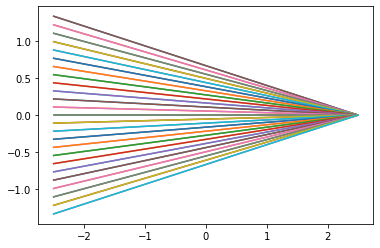

In [42]:
x1,x2 = (0,0)
y1,y2 = (0,0)
z1,z2 = (2.5,-2.5)
rays = MakeFanBeamRays(50,np.pi/6,((x1,x2),(y1,y2),(z1,z2)),direction='y',adjust=0.025)

ifig=1;plt.close(ifig);plt.figure(ifig)
for ray in rays:
    plt.plot(ray[2],ray[1])

#### Testing Superposition

In [17]:
test_kernel = np.array([[[0,0,0],[0,0.1,0],[0,0,0]],
                     [[0,0.1,0],[0.1,0.4,0.1],[0,0.1,0]],
                     [[0,0,0],[0,0.1,0],[0,0,0]]])
test_array_1 = np.array([[[1,1],[1,1]],
                      [[1,1],[1,1]]])
voxel_info_1 = []
n=0
for x in range(len(test_array_1)):
    for y in range(len(test_array_1[0])):
        for z in range(len(test_array_1[0][0])):
            voxel_info_1.append({})
            voxel_info_1[n]['indices'] = (x+1,y+1,z+1)
            voxel_info_1[n]['TERMA'] = 1 #- 0.01*n
            voxel_info_1[n]['d'] = n % 2 
            n += 1

Superposition(test_kernel,(2,2,2),(3,3,3),(2,2,2),[voxel_info_1])
# Superposition(test_kernel,(2,2,2),(3,3,3),(2/3,2/3,2/3),voxel_info_1)
# Superposition?

TypeError: Superposition() missing 1 required positional argument: 'beam_coor'

In [14]:
test_kernel = np.array([[[0,0,0],[0,0.1,0],[0,0,0]],
                     [[0,0.1,0],[0.1,0.4,0.1],[0,0.1,0]],
                     [[0,0,0],[0,0.1,0],[0,0,0]]])

In [15]:
test_array_1 = np.array([[[1,1],[1,1]],
                      [[1,1],[1,1]]])

test_array_2 = np.array([[[1,1],[0,0]],
                      [[0,0],[0,0]]])

In [20]:
test_array = test_array_2

voxel_info_1 = []
n=0
for x in range(len(test_array)):
    for y in range(len(test_array[0])):
        for z in range(len(test_array[0][0])):
            voxel_info_1.append({})
            voxel_info_1[n]['indices'] = (x+1,y+1,z+1)
            voxel_info_1[n]['TERMA'] = test_array[x][y][z]
            voxel_info_1[n]['d'] = 0.1
            n += 1

voxel_info_1

[{'indices': (1, 1, 1), 'TERMA': 1, 'd': 0.1},
 {'indices': (1, 1, 2), 'TERMA': 1, 'd': 0.1},
 {'indices': (1, 2, 1), 'TERMA': 0, 'd': 0.1},
 {'indices': (1, 2, 2), 'TERMA': 0, 'd': 0.1},
 {'indices': (2, 1, 1), 'TERMA': 0, 'd': 0.1},
 {'indices': (2, 1, 2), 'TERMA': 0, 'd': 0.1},
 {'indices': (2, 2, 1), 'TERMA': 0, 'd': 0.1},
 {'indices': (2, 2, 2), 'TERMA': 0, 'd': 0.1}]

In [21]:
sd.Superposition(test_kernel,(3,3,3),(3,3,3),(0.75,0.75,0.75),[voxel_info_1],4)
# sd.Superposition?

array([[[0.50758621, 0.50758621],
        [0.20965517, 0.20965517]],

       [[0.20965517, 0.20965517],
        [0.07310345, 0.07310345]]])

In [24]:
x1,x2 = (0,0)
y1,y2 = (0,0)
z1,z2 = (2,0.25)

Superposition(test_kernel,(3,3,3),(3,3,3),(0.75,0.75,0.75),[voxel_info_1],[((x1,x2),(y1,y2),(z1,z2))])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 1 is different from 3)

In [19]:
'''
making mu interpolation function
'''
filename = 'energy_absorption_coeffs.txt'

coeff_array = np.loadtxt(filename,skiprows=2,dtype=float)

# e_a_coeffs = [] # energy absorption coefficients

# for row in coeff_array:
#     e_a_coeffs.append([row[0],row[1]])
# e_a_coeffs = np.array(e_a_coeffs)

# exponentially interpolate 
mu_linear = interpolate.interp1d(np.log(coeff_array.T[0]),np.log(coeff_array.T[1]),kind='linear',fill_value='extrapolate')
mu_l = lambda energy, material: np.exp(mu_linear(np.log(energy))) # CHANGE THIS LATER TO A REAL FUNCTION

mu_mass = interpolate.interp1d(np.log(coeff_array.T[0]),np.log(coeff_array.T[2]),kind='linear',fill_value='extrapolate')
mu_m = lambda energy, material: np.exp(mu_mass(np.log(energy))) # CHANGE THIS LATER TO A REAL FUNCTION

[{'d': 0.0, 'indices': (4, 2, 4)},
 {'d': 0.16709129580497856, 'indices': (4, 2, 3)},
 {'d': 0.23392781412696972, 'indices': (4, 1, 3)},
 {'d': 0.601528664897923, 'indices': (3, 1, 3)},
 {'d': 0.10025477748298717, 'indices': (3, 1, 2)},
 {'d': 0.7017834423809102, 'indices': (2, 1, 2)},
 {'d': 0.20050955496597395, 'indices': (1, 1, 2)},
 {'d': 0.5012738874149358, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)}]

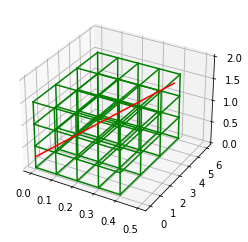

In [34]:
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 5 
Ny = 4 
Nz = 4 

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 0.1
dy = 2
dz = 0.5

# initial and final coordinates of the beam
x1,x2 = (0.5,0)
y1,y2 = (3,0)
z1,z2 = (2,0.25)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

# beam info and filename
ini_energy = 0.120 # in MeV
filename = 'energy_absorption_coeff.txt'

Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)
# TERMA((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),ini_energy,mu)

[{'d': 0.0, 'indices': (3, 1, 2)},
 {'d': 2.5000000000000004, 'indices': (2, 1, 2)},
 {'d': 2.5, 'indices': (1, 1, 2)},
 {'d': 0.0, 'indices': (1, 1, 2)}]

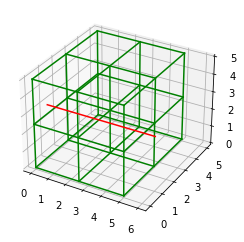

In [19]:
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 3
Ny = 3
Nz = 3

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 2.5
dy = 2.5
dz = 2.5

# initial and final coordinates of the beam
x1,x2 = (6,0)
y1,y2 = (1,1)
z1,z2 = (3,3)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)

In [10]:
x1,x2 = (0.6,0.6)
y1,y2 = (0.4,0.4)
z1,z2 = (4,-6)

In [13]:
MakeFanBeamRays(6,30,((x1,x2),(y1,y2),(z1,z2)))

[((0.6, 7.005331196646275),
  (0.42500000000000004, 0.42500000000000004),
  (4, -6)),
 ((0.6, 0.6), (0.42500000000000004, 0.42500000000000004), (4, -6)),
 ((0.6, -5.805331196646276),
  (0.42500000000000004, 0.42500000000000004),
  (4, -6)),
 ((0.6, 7.005331196646275), (0.375, 0.375), (4, -6)),
 ((0.6, 0.6), (0.375, 0.375), (4, -6)),
 ((0.6, -5.805331196646276), (0.375, 0.375), (4, -6))]

In [18]:
%%time
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 10
Ny = 10
Nz = 10

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 0.1
dy = 0.1
dz = 0.1

# initial and final coordinates of the beam
x1,x2 = (0.6,0.6)
y1,y2 = (0.4,0.4)
z1,z2 = (4,-6)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

# beam info and filename
beam_energy = 0.120 # in MeV
fluence_0 = 100000000 # photon/cm^2
filename = 'energy_absorption_coeffs.txt'

# kernel info
kernelname = '../Topas/RealKernel1.csv'
kernel_size = (1,1,1) # cm 

# Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)
# TERMA((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),beam_energy,fluence_0,mu)

dose1 = Dose_Calculator((Nx,Ny,Nz),(dx,dy,dz),[((x1,x2),(y1,y2),(z1,z2))],(xplane1,yplane1,zplane1),[beam_energy],[fluence_0],filename,kernelname,kernel_size,(0.5,0.5,0.5))
# dose2 = sd.Dose_Calculator((Nx,Ny,Nz),(dx,dy,dz),[((x1,x2),(y1,y2),(z1,z2))],(xplane1,yplane1,zplane1),[beam_energy],[fluence_0],filename,kernelname,kernel_size,4)
# Dose_Calculator?

CPU times: user 9.13 s, sys: 90.8 ms, total: 9.22 s
Wall time: 9.24 s


In [85]:
np.max(dose1-dose2)

0.4496674925164601

In [ ]:
CPU times: user 9.86 s, sys: 124 ms, total: 9.98 s
Wall time: 10 s

In [12]:
ini_num_photons = 10000000
radius = 0.1 # cm 
fluence_0 = ini_num_photons/(np.pi*radius**2)
fluence_0

318309886.1837907

In [15]:
%%time 

# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 51
Ny = 51
Nz = 51

# distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
dx = 0.1
dy = 0.1
dz = 0.1

# initial and final coordinates of the beam
x1,x2 = (0,0)
y1,y2 = (0,0)
z1,z2 = (2.5,-2.5)

# adjustment from center 
adjust = 0.025

# initial plane coordinates
xplane1 = -2.5
yplane1 = -2.5
zplane1 = -2.5

# beam info and filename
beam_energy = 0.120 # in MeV
fluence_0 = 3.183098862 * 10**8 # photon/cm^2
filename = 'energy_absorption_coeffs.txt'

# kernel info
kernelname = '../Topas/RealKernel1.csv'
kernel_size = (1,1,1) # cm 

# Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)
# TERMA((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),beam_energy,fluence_0,mu)

dose = Dose_Calculator((Nx,Ny,Nz),(dx,dy,dz),[((x1+adjust,x2+adjust),(y1+adjust,y2+adjust),(z1,z2)),((x1-adjust,x2-adjust),(y1+adjust,y2+adjust),(z1,z2)),((x1+adjust,x2+adjust),(y1-adjust,y2-adjust),(z1,z2)),((x1-adjust,x2-adjust),(y1-adjust,y2-adjust),(z1,z2))],(xplane1,yplane1,zplane1),beam_energy,fluence_0,filename,kernelname,kernel_size)



CPU times: user 1h 40min 36s, sys: 476 ms, total: 1h 40min 36s
Wall time: 1h 40min 50s


In [ ]:
CPU times: user 1h 39min 20s, sys: 407 ms, total: 1h 39min 21s
Wall time: 1h 39min 35s

In [22]:
import pickle 

dose_im_array = []

for dose_row in dose:
    dose_im_array.append(dose_row['energy'])

dose_im_array = np.array(dose_im_array)

dose_im_array = dose_im_array.reshape(Nx-1,Ny-1,Nz-1)

np.max(dose_im_array)

13620.513411533808

In [16]:
import pickle 
pickle.dump(dose,open('dose_tilted.pickle','wb'))

In [17]:
s = sp.Spek(kvp=120,th=12) # Generate a spectrum (80 kV, 12 degree tube angle)
s.filter('Al', 4.0) # Filter by 4 mm of Al

hvl = s.get_hvl1() # Get the 1st HVL in mm Al

# print(hvl) # Print out the HVL value (Python3 syntax)

s.get_spectrum()

# sp.Spek?

(array([  1.25,   1.75,   2.25,   2.75,   3.25,   3.75,   4.25,   4.75,
          5.25,   5.75,   6.25,   6.75,   7.25,   7.75,   8.25,   8.75,
          9.25,   9.75,  10.25,  10.75,  11.25,  11.75,  12.25,  12.75,
         13.25,  13.75,  14.25,  14.75,  15.25,  15.75,  16.25,  16.75,
         17.25,  17.75,  18.25,  18.75,  19.25,  19.75,  20.25,  20.75,
         21.25,  21.75,  22.25,  22.75,  23.25,  23.75,  24.25,  24.75,
         25.25,  25.75,  26.25,  26.75,  27.25,  27.75,  28.25,  28.75,
         29.25,  29.75,  30.25,  30.75,  31.25,  31.75,  32.25,  32.75,
         33.25,  33.75,  34.25,  34.75,  35.25,  35.75,  36.25,  36.75,
         37.25,  37.75,  38.25,  38.75,  39.25,  39.75,  40.25,  40.75,
         41.25,  41.75,  42.25,  42.75,  43.25,  43.75,  44.25,  44.75,
         45.25,  45.75,  46.25,  46.75,  47.25,  47.75,  48.25,  48.75,
         49.25,  49.75,  50.25,  50.75,  51.25,  51.75,  52.25,  52.75,
         53.25,  53.75,  54.25,  54.75,  55.25,  55.75,  56.25, 